# 1. Avaliação Inicial

> Abordagens
* Carregar os dados
* Checar Missings
* Checar Duplicadas
* Separar o Target

> Informações do problema:
* Dados gerados artificialmente através de deep learning;
* Problema de Regressão (TARGET: `Rings`)
* Metrica de Avaliação: Root Mean Squared Log Error (RMSLE)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils.feature_engineering import create_features

In [2]:
data = pd.read_csv('./database/train.csv')
data.shape

(90615, 10)

In [3]:
data.duplicated().any()

False

In [4]:
data.isna().any()

id                False
Sex               False
Length            False
Diameter          False
Height            False
Whole weight      False
Whole weight.1    False
Whole weight.2    False
Shell weight      False
Rings             False
dtype: bool

In [5]:
X = data.drop(columns= ['id','Rings']).copy()
y = data['Rings'].copy()

In [6]:
from utils.feature_engineering import create_features
X = create_features(X).copy()

# 2. Modeling

## 2.1 Clustering

### 2.1.1 Data Preparation

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import TargetEncoder, StandardScaler, QuantileTransformer
import pickle

* Criação da Pipeline

In [8]:
# dp_std: dataprep_standard

dp_std_num_features = X.select_dtypes(exclude= 'object').columns.to_list()
dp_std_cat_features = X.select_dtypes(include= 'object').columns.to_list()

dp_std_num_pipeline = Pipeline([
    ('dp_std_num_imputer', SimpleImputer(strategy= 'median')),
    ('dp_std_num_scaler', StandardScaler()),
    ('dp_std_num_transformer', QuantileTransformer(output_distribution= 'normal'))
])

dp_std_cat_pipeline = Pipeline([
    ('dp_std_cat_imputer', SimpleImputer(strategy= 'most_frequent')),
    ('dp_std_cat_encoder', TargetEncoder())
])


dp_std_preprocessor = ColumnTransformer([
    ('dp_std_num', dp_std_num_pipeline, dp_std_num_features),
    ('dp_std_cat', dp_std_cat_pipeline, dp_std_cat_features)
])

dp_std_pipeline = Pipeline(
    steps= [('dp_std_preprocessor', dp_std_preprocessor)]
)

* Ajuste da Pipeline + Geração dos Artefatos

In [9]:
# Ajustando aos dados de treino
dp_std_pipeline.fit(X,y)

# Salvando o nome das features
dp_std_features = dp_std_num_features + dp_std_pipeline.named_steps['dp_std_preprocessor'].named_transformers_['dp_std_cat'].named_steps['dp_std_cat_encoder'].get_feature_names_out(dp_std_cat_features).tolist()

# Salvando o Artefato -- Pipeline
with open('./artefatos/01_std_dataprep/std_pipeline.pkl', mode= 'wb') as file:
    pickle.dump(dp_std_pipeline, file)

# Salvando o Artefato -- Lista de Features
with open('./artefatos/01_std_dataprep/std_pipeline_features.pkl', mode= 'wb') as file:
    pickle.dump(dp_std_features, file)

* Aplicação da Pipeline

In [10]:
X_dp_std = pd.DataFrame(
    data =  dp_std_pipeline.transform(X),
    columns= dp_std_features
)

### 2.1.2 Dimensionality Reduction

* Ajuste e Geração do Artefato (80% da Variância)

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components= 0.95)
pca.fit(X_dp_std)

# Salvando o Artefato -- PCA
with open('./artefatos/02_pca/pca.pkl', mode= 'wb') as file:
    pickle.dump(pca, file)

* Aplicação do PCA

In [12]:
X_reduced = pd.DataFrame(pca.transform(X_dp_std))

### 2.1.3 Gaussian Mixture Model

* Encontrando os melhores parâmetros

In [13]:
from sklearn.mixture import GaussianMixture
from utils.clustering import gmm_tunning

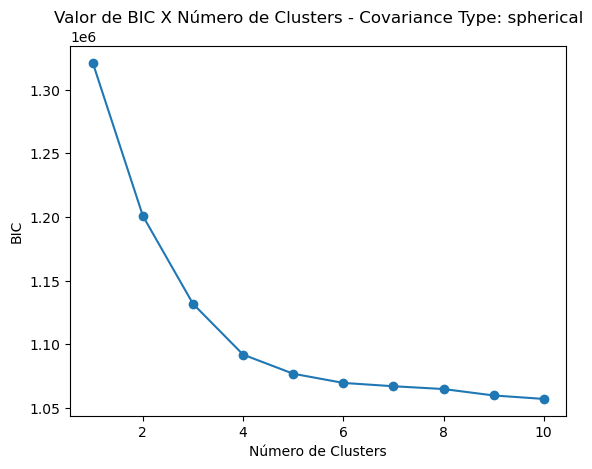

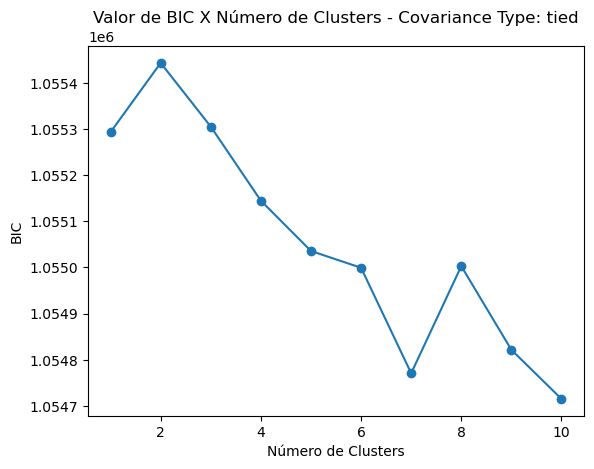

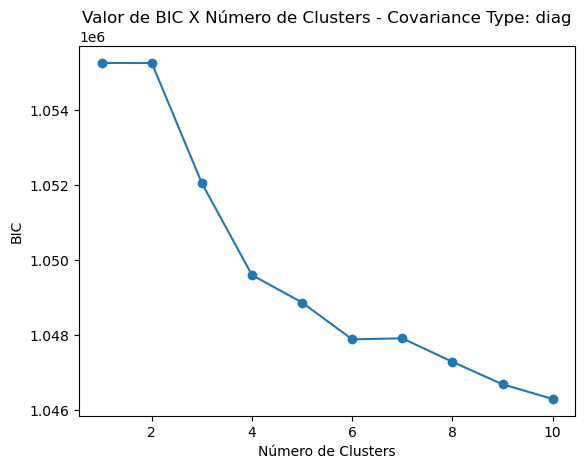

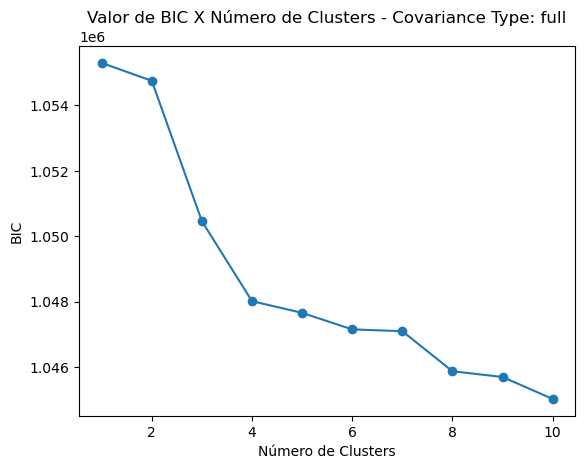

Melhor configuração: ('full', 10)
Menor BIC: 1045024.3753958384


In [14]:
best_config = gmm_tunning(
    data= X_reduced,
    n= 10,
    random_state= 1
)

* Ajustando o modelo e Criando o Artefato

In [15]:
gmm = GaussianMixture(n_components= best_config[1], covariance_type= best_config[0]).fit(X_reduced)

# Criando Artefato -- Modelo GMM
with open('./artefatos/03_gmm/gmm_model.pkl', mode= 'wb') as file:
    pickle.dump(gmm, file)

* Atualizando os dados originais

In [16]:
X['Cluster'] = gmm.predict(X_reduced)
# Transformando em Object (Para utilizar como variável categórica)
X['Cluster'] = X['Cluster'].astype('object')

# 2.2 Modelling

## 2.2.1 Data Preparation

* Split Treino/Teste

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state = 1, shuffle= True)

# Salvando os índices
train_idx = X_train.index
test_idx = X_test.index

* Data Preparation

In [18]:
#Sufixo 'dp_bsl' = dataprep_baseline
from sklearn.preprocessing import OneHotEncoder

# Filtrando as colunas
dp_bsl_num_features = X.select_dtypes(exclude='object').columns.to_list()
dp_bsl_cat_features = X.select_dtypes(include='object').columns.to_list()

# Criando a Pipeline para variáveis numéricas
dp_bsl_num_pipeline = Pipeline([
    ('dp_bsl_num_imputer', SimpleImputer(strategy='median')),
    ('dp_bsl_num_scaler', StandardScaler()),
    ('dp_bsl_num_transformer', QuantileTransformer(output_distribution='normal'))
])

# Criando a Pipeline para variáveis categóricas
dp_bsl_cat_pipeline = Pipeline([
    ('dp_bsl_cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('dp_bsl_cat_encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Criando o preprocessador
dp_bsl_preprocessor = ColumnTransformer([
    ('dp_bsl_num_pipeline', dp_bsl_num_pipeline, dp_bsl_num_features),
    ('dp_bsl_cat_pipeline', dp_bsl_cat_pipeline, dp_bsl_cat_features)
])

# Criando a Pipeline
dp_bsl_pipeline = Pipeline(
    steps= [('dp_bsl_preprocessor', dp_bsl_preprocessor)]
)

* Ajuste aos dados de treino e criação do artefato

In [19]:
# Ajuste aos dados de treino
dp_bsl_pipeline.fit(X_train, y_train)

# Salvando a lista de features
dp_bsl_features = dp_bsl_num_features + dp_bsl_pipeline.named_steps['dp_bsl_preprocessor'].named_transformers_['dp_bsl_cat_pipeline'].named_steps['dp_bsl_cat_encoder'].get_feature_names_out(dp_bsl_cat_features).tolist()

# Geração do Artefato -- Pipeline Baseline
with open('./artefatos/04_baseline/pipeline.pkl', mode= 'wb') as file:
    pickle.dump(dp_bsl_pipeline, file)

# Geração do Artefato -- Features Baseline
with open('./artefatos/04_baseline/pipeline_features_out.pkl', mode= 'wb') as file:
    pickle.dump(dp_bsl_features, file)

* Transformando os dados de Treino e Teste

In [20]:
X_train_bsl = pd.DataFrame(dp_bsl_pipeline.transform(X_train), columns= dp_bsl_features, index= train_idx)

X_test_bsl = pd.DataFrame(dp_bsl_pipeline.transform(X_test), columns= dp_bsl_features, index= test_idx)

assert (X_train_bsl.columns == X_test_bsl.columns).all()

## 2.2.2 Baseline

### 2.2.2.1 Regressão Linear Clássica

In [21]:
# Para Modelo de Regressão Linear
import statsmodels.api as sm
# Para testar homocedasticidade
import statsmodels.stats.api as sms

In [22]:
# Adicionando o Intercepto
X_train_bsl_reg_lin = sm.add_constant(X_train_bsl)

model = sm.OLS(y_train, X_train_bsl_reg_lin).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     3057.
Date:                Mon, 22 Jul 2024   Prob (F-statistic):               0.00
Time:                        11:01:22   Log-Likelihood:            -1.3235e+05
No. Observations:               63430   AIC:                         2.648e+05
Df Residuals:                   63395   BIC:                         2.651e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

<Axes: title={'center': 'P-Values'}>

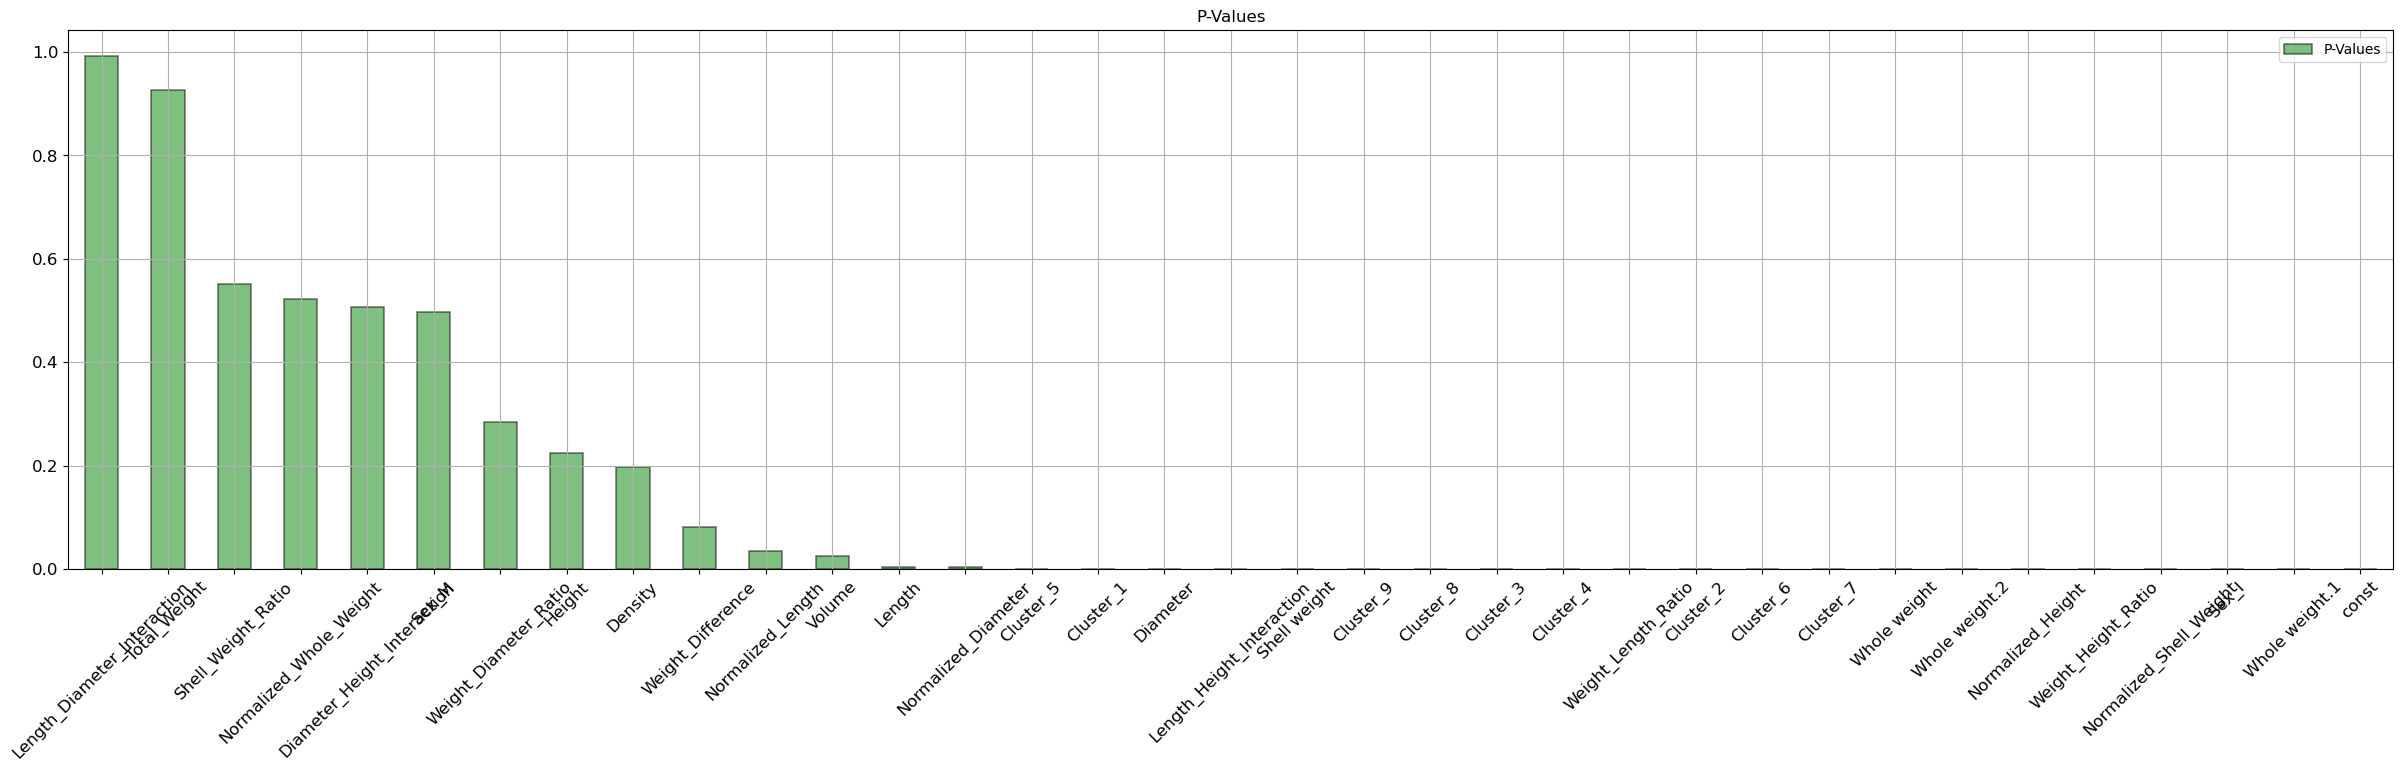

In [23]:
# Observando os p-valores
model.pvalues.sort_values(ascending=False).plot(kind='bar', figsize=(30, 7), title='P-Values', grid=True, rot=45, color='green', edgecolor='black', linewidth=1.2, alpha=0.5, width=0.5, legend=True, fontsize=12, label='P-Values')

* Observando os p-valores, podemos ver que algumas variáveis estão dentro da zona de rejeição (considerando um nível de significancia de 0.05). Irei remover a variável de maior p-valor e retreinar o modelo, em um processo iterativo, até que nenhuma variável apresente p-valor acima do nível de significancia.

In [24]:
log = list()

for _ in X_train_bsl_reg_lin.columns:
    
    # Realiza o filtro na listagem de p-valor
    mask = model.pvalues.loc[model.pvalues >= 0.40].sort_values(ascending= False)

    # Quebra a execução caso não haja features com p-valor acima de 0.40
    if mask.empty == True:
        break
    
    # Atualiza o dataframe removendo a feature
    X_train_bsl_reg_lin = X_train_bsl_reg_lin.drop(columns = mask.index[0])

    # Salva a feature e seu p-valor
    log.append((mask.index[0], mask.iloc[0]))

    # Retreina o modelo
    model = sm.OLS(y_train, X_train_bsl_reg_lin).fit()

* Verificando se os resíduos são homocedásticos, ou seja, se a variância dos resíduos é constante ao longo de todas as observações do target. É um fundamento importante da regressão linear clássica.

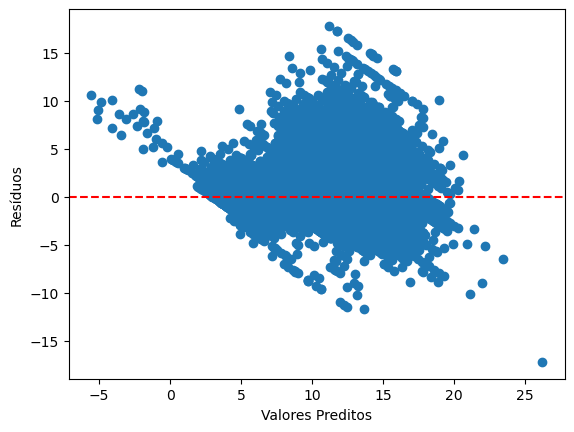

In [25]:
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

> O gráfico acima por si só já nos mostra indícios de heterocedasticidade, uma vez que a distribuição dos resíduos não é aleatória.

> Vamos aplicar testes mais formais para checar homocedasticidade: `Teste de Breusch-Pagan` e `Teste de White`

* Teste de Breusch-Pagan / Teste de White

Hipótese Nula $(H_{0})$: Não há heterocedasticidade

Hipótese Alternativa $(H_{a})$: Há heterocedasticidade

Nível de Significancia $(\alpha) = 0.05$

In [26]:
breusch_pagan_test = sms.het_breuschpagan(model.resid, model.model.exog)
print(f'Estatística do Teste: {breusch_pagan_test[0]}\np-valor: {breusch_pagan_test[1]}')

Estatística do Teste: 5075.69885115079
p-valor: 0.0


In [27]:
white_test = sms.het_white(model.resid, model.model.exog)
print(f'Estatística do Teste: {white_test[0]}\np-valor: {white_test[1]}')

Estatística do Teste: 8038.708896738693
p-valor: 0.0


Um p-valor abaixo do nível de significancia, significa que podemos rejeitar a hipótese nula, indicando que há presença de heterocedasticidade. Logo, ambos os testes confirmam nossa suspeita anterior: Existe presença de heterocedasticidade no resíduo.

Para contornar este problema, normalmente testam-se transformações (log, raiz quadrada, etc) nos dados, ou alterna-se a abordagem, utilizando um modelo mais robusto.

* Avaliando o Modelo

In [28]:
from sklearn.metrics import root_mean_squared_log_error
print("RMSLE {Treino}:",root_mean_squared_log_error(y_train, model.predict(X_train_bsl_reg_lin).abs()))
X_test_bsl_reg_lin = sm.add_constant(X_test_bsl)
X_test_bsl_reg_lin = X_test_bsl_reg_lin[X_train_bsl_reg_lin.columns]
print("RMSLE {Teste}:",root_mean_squared_log_error(y_test, model.predict(X_test_bsl_reg_lin).abs()))

RMSLE {Treino}: 0.1627392917393263
RMSLE {Teste}: 0.1604934104279704


### 2.2.2.2 Outros modelos

In [29]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from utils.model_selection import RMSLE_by_model

In [30]:
models = [
    LGBMRegressor(n_jobs=-1, random_state = 1),
    XGBRegressor(n_jobs=-1, random_state= 1),
    RandomForestRegressor(n_jobs=-1, random_state= 1),
    GradientBoostingRegressor(random_state=1),
    DecisionTreeRegressor(random_state=1),
    LinearRegression(),
    Ridge(random_state=1),
    Lasso(random_state=1),
    ElasticNet(random_state=1),
    SVR(kernel='poly'),
]

for model in models:
    name = str(model)[:str(model).find("(")]

    model.fit(X_train_bsl, y_train)
    
    display(RMSLE_by_model(name, model, X_train_bsl, y_train, X_test_bsl, y_test))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4956
[LightGBM] [Info] Number of data points in the train set: 63430, number of used features: 34
[LightGBM] [Info] Start training from score 9.700347


,Modelo,Set,RMSLE
0,LGBMRegressor,Treino,0.145188
1,LGBMRegressor,Teste,0.150049


,Modelo,Set,RMSLE
0,XGBRegressor,Treino,0.132283
1,XGBRegressor,Teste,0.151654


,Modelo,Set,RMSLE
0,RandomForestRegressor,Treino,0.059554
1,RandomForestRegressor,Teste,0.152744


,Modelo,Set,RMSLE
0,GradientBoostingRegressor,Treino,0.151916
1,GradientBoostingRegressor,Teste,0.152466


,Modelo,Set,RMSLE
0,DecisionTreeRegressor,Treino,0.000000
1,DecisionTreeRegressor,Teste,0.215097


,Modelo,Set,RMSLE
0,LinearRegression,Treino,0.162678
1,LinearRegression,Teste,0.160451


,Modelo,Set,RMSLE
0,Ridge,Treino,0.162686
1,Ridge,Teste,0.160451


,Modelo,Set,RMSLE
0,Lasso,Treino,0.210832
1,Lasso,Teste,0.212248


,Modelo,Set,RMSLE
0,ElasticNet,Treino,0.195977
1,ElasticNet,Teste,0.196790


,Modelo,Set,RMSLE
0,SVR,Treino,0.165227
1,SVR,Teste,0.165669


* Com base nos resultados dos testes, o GradientBoosting e o LGBM indicaram maiores potenciais para resolver o problema

## 2.2.3 Modelo Final

### 2.2.3.1 Data Preparation

* Criando o Pipeline

In [31]:
#Sufixo 'dp_mfl' = dataprep_modelofinal
#Mesma pipeline do baseline

from sklearn.preprocessing import OneHotEncoder

# Filtrando as colunas
dp_mfl_num_features = X.select_dtypes(exclude='object').columns.to_list()
dp_mfl_cat_features = X.select_dtypes(include='object').columns.to_list()

# Criando a Pipeline para variáveis numéricas
dp_mfl_num_pipeline = Pipeline([
    ('dp_mfl_num_imputer', SimpleImputer(strategy='median')),
    ('dp_mfl_num_scaler', StandardScaler()),
    ('dp_mfl_num_transformer', QuantileTransformer(output_distribution='normal'))
])

# Criando a Pipeline para variáveis categóricas
dp_mfl_cat_pipeline = Pipeline([
    ('dp_mfl_cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('dp_mfl_cat_encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Criando o preprocessador
dp_mfl_preprocessor = ColumnTransformer([
    ('dp_mfl_num_pipeline', dp_mfl_num_pipeline, dp_mfl_num_features),
    ('dp_mfl_cat_pipeline', dp_mfl_cat_pipeline, dp_mfl_cat_features)
])

# Criando a Pipeline
dp_mfl_pipeline = Pipeline(
    steps= [('dp_mfl_preprocessor', dp_mfl_preprocessor)]
)

* Ajustando o Pipeline aos Dados de Treino e Gerando o Artefato

In [32]:
# Ajuste aos dados de treino
dp_mfl_pipeline.fit(X_train, y_train)

# Salvando a lista de features
dp_mfl_features = dp_mfl_num_features + dp_mfl_pipeline.named_steps['dp_mfl_preprocessor'].named_transformers_['dp_mfl_cat_pipeline'].named_steps['dp_mfl_cat_encoder'].get_feature_names_out(dp_mfl_cat_features).tolist()

# Geração do Artefato -- Pipeline Modelo Final
with open('./artefatos/05_modelo_final/pipeline.pkl', mode= 'wb') as file:
    pickle.dump(dp_mfl_pipeline, file)

# Geração do Artefato -- Features Modelo Final
with open('./artefatos/05_modelo_final/pipeline_features_out.pkl', mode= 'wb') as file:
    pickle.dump(dp_mfl_features, file)

* Transformando os dados de Treino e Teste

In [33]:
X_train_mfl = pd.DataFrame(dp_mfl_pipeline.transform(X_train), columns= dp_mfl_features, index= train_idx)

X_test_mfl = pd.DataFrame(dp_mfl_pipeline.transform(X_test), columns= dp_mfl_features, index= test_idx)

assert (X_train_mfl.columns == X_test_mfl.columns).all()

### 2.2.3.2 Feature Selection

* Remoção por Recursive Feature Elimination

In [52]:
from utils.feature_selection import rfe_kfold
rfe_frame = rfe_kfold(
    X= X_train_mfl,
    y= y_train,
    model= GradientBoostingRegressor(random_state= 1),
    folds= 3,
    fold_random_state= 1
)

In [54]:
rfe_selected_features = rfe_frame.loc[rfe_frame['score_validacao'] == rfe_frame['score_validacao'].min(), ['feature_list']].values[0][0]

In [55]:
# Aplicando aos conjuntos de treino e teste
X_train_mfl_fs = X_train_mfl[rfe_selected_features].copy()
X_test_mfl_fs = X_test_mfl[rfe_selected_features].copy()

# Salvando os artefatos
with open('./artefatos/05_modelo_final/feature_selection_step2_rfecv.pkl', mode= 'wb') as file:
    pickle.dump(rfe_selected_features, file)

* Testando GradientBoosting pós feature Selection

In [60]:
model = GradientBoostingRegressor(random_state= 1)

model.fit(X_train_mfl_fs, y_train)

display(RMSLE_by_model('GradientBoostingRegressor', model, X_train_mfl_fs, y_train, X_test_mfl_fs, y_test))

,Modelo,Set,RMSLE
0,GradientBoostingRegressor,Treino,0.152230
1,GradientBoostingRegressor,Teste,0.152704


* Testando o LGBM pós feature Selection

In [61]:
model2 = LGBMRegressor(random_state= 1, n_jobs=-1)

model2.fit(X_train_mfl_fs, y_train)

display(RMSLE_by_model('LGBMRegressor', model2, X_train_mfl_fs, y_train, X_test_mfl_fs, y_test))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3303
[LightGBM] [Info] Number of data points in the train set: 63430, number of used features: 16
[LightGBM] [Info] Start training from score 9.700347


,Modelo,Set,RMSLE
0,LGBMRegressor,Treino,0.145409
1,LGBMRegressor,Teste,0.150017


### 2.2.3.3 Hyperparameter Tunning: Modelo I - Gradient Boosting

* Fazendo a busca utilizando BayesSearch + Cross Validation

In [69]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

param_grid_grad_boosting = {
    'loss': Categorical(['squared_error', 'absolute_error', 'huber', 'quantile']),
    'learning_rate': Real(0.01, 0.3, 'log-uniform'),
    'n_estimators': Integer(50, 1000),
    'subsample': Real(0.5, 1.0),
    'criterion': Categorical(['friedman_mse', 'squared_error']),
    'min_samples_split': Integer(2, 50),
    'min_samples_leaf': Integer(1, 50),
    'min_weight_fraction_leaf': Real(0.0, 0.5),
    'max_depth': Integer(3, 15),
    'min_impurity_decrease': Real(0.0, 0.1),
    'init': Categorical([None]),
    'random_state': Categorical([None, 42]),
    'max_features': Categorical(['sqrt', 'log2']),
    'alpha': Real(0.1, 0.9),
    'verbose': Categorical([0, 1]),
    'max_leaf_nodes': Integer(2, 100),
    'warm_start': Categorical([False, True]),
    'validation_fraction': Real(0.1, 0.5),
    'n_iter_no_change': Integer(1, 20),
    'tol': Real(1e-4, 1e-2, 'log-uniform'),
    'ccp_alpha': Real(0.0, 0.1)
}

gbr = GradientBoostingRegressor()

opt_grad_boosting = BayesSearchCV(
    estimator= gbr,
    search_spaces= param_grid_grad_boosting,
    n_iter= 35,
    cv= 5,
    n_jobs= -1,
    verbose= 1,
    random_state= 1
)

opt_grad_boosting.fit(X_train_mfl_fs, y_train)

print("Melhores hiperparâmetros encontrados:")
print(opt_grad_boosting.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

* Testando o Modelo com os melhores hiperparametros

In [70]:
model = GradientBoostingRegressor(**opt_grad_boosting.best_params_)

model.fit(X_train_mfl_fs, y_train)

display(RMSLE_by_model('GradientBoostingRegressor', model, X_train_mfl_fs, y_train, X_test_mfl_fs, y_test))

,Modelo,Set,RMSLE
0,GradientBoostingRegressor,Treino,0.149229
1,GradientBoostingRegressor,Teste,0.151192


* Salvando o Artefato

In [76]:
# Melhores Parametros
with open('./artefatos/05_modelo_final/grad_boosting_best_params.pkl', mode= 'wb') as file:
    pickle.dump(opt_grad_boosting.best_params_, file)

# Modelo Treinado
with open('./artefatos/05_modelo_final/grad_boosting_trained_model_70perc_data.pkl', mode= 'wb') as file:
    pickle.dump(model, file)

### 2.2.3.4 Hyperparameter Tunning: Modelo II - LGBM

In [80]:
param_grid_lgbm = {
    'feature_selection__k': Integer(5, X_train.shape[1]),
    'boosting_type': Categorical(['gbdt', 'dart']),
    'num_leaves': Integer(20, 150),
    'max_depth': Integer(-1, 50),
    'learning_rate': Real(0.01, 0.3, 'log-uniform'),
    'n_estimators': Integer(50, 1000),
    'subsample_for_bin': Integer(20000, 300000),
    'objective': Categorical([None, 'regression', 'regression_l1', 'huber', 'fair', 'poisson', 'quantile', 'mape', 'gamma', 'tweedie']),
    'class_weight': Categorical([None, 'balanced']),
    'min_split_gain': Real(0.0, 0.1),
    'min_child_weight': Real(1e-3, 10, 'log-uniform'),
    'min_child_samples': Integer(20, 500),
    'subsample': Real(0.5, 1.0),
    'subsample_freq': Integer(0, 10),
    'colsample_bytree': Real(0.5, 1.0),
    'reg_alpha': Real(1e-4, 1.0, 'log-uniform'),
    'reg_lambda': Real(1e-4, 1.0, 'log-uniform'),
    'random_state': Categorical([None, 42]),
    'silent': Categorical([True, False]),
    'importance_type': Categorical(['split', 'gain']),
    'max_bin': Integer(100, 500),
    'num_iterations': Integer(100, 1000),
    'drop_rate': Real(0.1, 0.5),
    'skip_drop': Real(0.1, 0.5),
    'max_drop': Integer(50, 100),
    'uniform_drop': Categorical([True, False]),
    'xgboost_dart_mode': Categorical([True, False]),
    'drop_seed': Integer(1, 100),
    'top_rate': Real(0.1, 0.5),
    'other_rate': Real(0.1, 0.5),
    'min_data_in_leaf': Integer(20, 500),
    'path_smooth': Real(0.0, 1.0),
    'feature_fraction': Real(0.5, 1.0),
    'bagging_fraction': Real(0.5, 1.0),
    'bagging_freq': Integer(0, 10),
    'first_metric_only': Categorical([True, False])
}

lgbm = LGBMRegressor(n_jobs= -1)

opt_lgbm = BayesSearchCV(
    estimator= lgbm,
    search_spaces= param_grid_lgbm,
    n_iter= 30,
    cv= 5,
    n_jobs= -1,
    verbose= 2,
    random_state= 1
)

opt_lgbm.fit(X_train_mfl_fs, y_train)

print("Melhores hiperparâmetros encontrados:")
print(opt_lgbm.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

c:\Users\Leonardo\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: feature_selection__k
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=216 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] feature_fraction is set=0.7964512229311099, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.7964512229311099
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.5 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=9 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: feature_selection__k
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=216 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] feature_fraction is set=0.7964512229311099, colsample_

* Testando o Modelo com os melhores hiperparametros

In [81]:
model = LGBMRegressor(**opt_lgbm.best_params_, n_jobs=-1)

model.fit(X_train_mfl_fs, y_train)

display(RMSLE_by_model('LGBMRegressor', model, X_train_mfl_fs, y_train, X_test_mfl_fs, y_test))

c:\Users\Leonardo\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: feature_selection__k
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=216 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] feature_fraction is set=0.7964512229311099, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.7964512229311099
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.5 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=9 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: feature_selection__k
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=216 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] feature_fraction is set=0.7964512229311099, colsample_

,Modelo,Set,RMSLE
0,LGBMRegressor,Treino,0.144859
1,LGBMRegressor,Teste,0.148666


* Salvando o Artefato

In [84]:
# Melhores Parametros
with open('./artefatos/05_modelo_final/lgbm_best_params.pkl', mode= 'wb') as file:
    pickle.dump(opt_lgbm.best_params_, file)

# Modelo Treinado
with open('./artefatos/05_modelo_final/lgbm_trained_model_70perc_data.pkl', mode= 'wb') as file:
    pickle.dump(model, file)